# Load Data & Support Functions

In [ ]:
import numpy as np
import pandas as pd

columns = ['year', 'month', 'max_temp', 'min_temp', 'frost_days', 'monthly_rainfall']

cardiff_dframe      = pd.DataFrame(np.load('cardiff.npy'), columns=columns)
aberporth_dframe    = pd.DataFrame(np.load('aberporth.npy'), columns=columns)
valley_dframe       = pd.DataFrame(np.load('valley.npy'), columns=columns)

dataset = (
    pd.concat([cardiff_dframe, aberporth_dframe, valley_dframe], ignore_index=True)
    .sort_values(['year', 'month'])
    .reset_index(drop=True)
)

def print_hyperparameter_tuning_results(grid, model_name, feature_set):
    print(f"\n{'='*69}")
    print(f"HYPERPARAMETER TUNING RESULTS: {model_name} ({feature_set})")
    print(f"{'='*69}")

    results_df = pd.DataFrame(grid.cv_results_)

    param_cols = [col for col in results_df.columns if col.startswith('param_')]

    summary_cols = param_cols + ['mean_test_score', 'std_test_score', 'rank_test_score']
    summary_df = results_df[summary_cols].copy()

    summary_df.columns = [col.replace('param_', '') for col in summary_cols]
    summary_df.columns = [col.replace('mean_test_score', 'CV_RMSE') for col in summary_df.columns]
    summary_df.columns = [col.replace('std_test_score', 'Std_RMSE') for col in summary_df.columns]
    summary_df.columns = [col.replace('rank_test_score', 'Rank') for col in summary_df.columns]

    # make positive
    summary_df['CV_RMSE'] = -summary_df['CV_RMSE']

    summary_df = summary_df.sort_values('Rank')

    print(f"\nTop 5 Hyperparameter Combinations (sorted by CV RMSE):")
    print("-" * 69)
    print(summary_df.head(5).to_string(index=False))

    if len(summary_df) <= 20:
        print(f"\nAll Hyperparameter Combinations:")
        print("-" * 69)
        print(summary_df.to_string(index=False))

    print(f"\nBest combination:")
    best_row = summary_df[summary_df['Rank'] == 1].iloc[0]
    for col in summary_df.columns:
        if col != 'Rank':
            print(f"  {col}: {best_row[col]}")

    return summary_df


def print_dataset_info(df):
    print("Dataset shape:", df.shape)
    print(df.head())


def print_training_header(model_type):
    print("\n" + "="*69)
    print(f"TRAINING {model_type} MODELS")
    print("="*69)


def print_model_results(model_name, best_params, best_cv_rmse, test_rmse, test_mae, test_r2, oob_score=None):
    print(f"\n--- {model_name} ---")
    print(f"Best Parameters: {best_params}")
    print(f"Best CV RMSE: {best_cv_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    if oob_score is not None:
        print(f"OOB Score: {oob_score:.4f}")


def print_all_models_summary(all_model_results):
    print("\n" + "="*69)
    print("SUMMARY: ALL MODELS - METRICS AND OPTIMAL HYPERPARAMETERS")
    print("="*69)

    for model_name, results in all_model_results.items():
        print(f"\n{model_name.upper()}")
        print("-" * 40)
        print(f"Model Type: {results['model_type']}")
        print(f"Feature Set: {results['feature_set']}")
        print(f"\nOptimal Hyperparameters:")
        for param, value in results['best_params'].items():
            print(f"  {param}: {value}")
        print(f"\nMetrics:")
        print(f"  Best CV RMSE: {results['best_cv_rmse']:.4f}")
        print(f"  Test RMSE: {results['test_rmse']:.4f}")
        print(f"  Test MAE: {results['test_mae']:.4f}")
        print(f"  Test R2: {results['test_r2']:.4f}")
        if 'oob_score' in results and results['oob_score'] is not None:
            print(f"  OOB Score: {results['oob_score']:.4f}")
        print(f"\nNote: Detailed hyperparameter tuning results were printed during training above.")

        year  month  max_temp  min_temp  frost_days  monthly_rainfall
1639  2000.0   10.0      15.0       7.1         0.0             267.6
2365  2020.0   12.0       9.3       3.0         6.0             265.6
2187  2015.0   12.0      12.3       7.8         0.0             254.2
1525  1997.0    8.0      23.3      15.5         0.0             251.0
1393  1993.0   12.0       9.6       3.6         6.0             249.5
...      ...    ...       ...       ...         ...               ...
1300  1991.0    5.0      16.7       8.2         0.0               3.5
1134  1986.0    9.0      15.1       8.1         0.0               3.4
137   1942.0    6.0      17.0       8.9         0.0               1.3
782   1976.0    8.0      20.4      13.5         0.0               0.8
1112  1986.0    2.0       2.3      -2.7        24.0               0.0

[2490 rows x 6 columns]


# Feature Engineering

In [ ]:
from sklearn.preprocessing import OneHotEncoder

month_encoder           = OneHotEncoder(sparse_output=False)
month_encoded           = month_encoder.fit_transform(dataset[['month']])
month_encoded_dataset   = pd.DataFrame(month_encoded, columns=month_encoder.get_feature_names_out(['month']))

features            = pd.concat([dataset[['min_temp', 'max_temp', 'frost_days']], month_encoded_dataset], axis=1)
features_baseline   = dataset[['min_temp', 'max_temp', 'frost_days']]
actual_rainfall     = dataset['monthly_rainfall']

features_knn_with_month = dataset[['min_temp', 'max_temp', 'frost_days', 'month']]

# Training Testing Split

In [3]:
from sklearn.preprocessing import StandardScaler

split_idx = int(len(features) * 0.8)

train_features = features.iloc[:split_idx]
test_features = features.iloc[split_idx:]
train_actual = actual_rainfall.iloc[:split_idx]
test_actual = actual_rainfall.iloc[split_idx:]

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

train_features_baseline = features_baseline.iloc[:split_idx]
test_features_baseline = features_baseline.iloc[split_idx:]
train_actual_baseline = actual_rainfall.iloc[:split_idx]
test_actual_baseline = actual_rainfall.iloc[split_idx:]

train_features_scaled_baseline = scaler.fit_transform(train_features_baseline)
test_features_scaled_baseline = scaler.transform(test_features_baseline)

train_features_knn_with_month = features_knn_with_month.iloc[:split_idx]
test_features_knn_with_month = features_knn_with_month.iloc[split_idx:]

# KNN Training

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

# Baseline
knn_pipe_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

knn_grid_baseline = GridSearchCV(knn_pipe_baseline, knn_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
knn_grid_baseline.fit(train_features_baseline, train_actual_baseline)

knn_baseline        = knn_grid_baseline.best_estimator_
knn_baseline_preds  = knn_baseline.predict(test_features_baseline)

# Month
knn_pipe_with_month = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

knn_grid_with_month = GridSearchCV(knn_pipe_with_month, knn_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
knn_grid_with_month.fit(train_features_knn_with_month, train_actual)

knn_with_month          = knn_grid_with_month.best_estimator_
knn_with_month_preds    = knn_with_month.predict(test_features_knn_with_month)

# Random Forest Training

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [ 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Baseline
rf_baseline         = RandomForestRegressor(random_state=69, oob_score=True, n_jobs=-1)
rf_grid_baseline    = GridSearchCV(rf_baseline, rf_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid_baseline.fit(train_features_scaled_baseline, train_actual_baseline)

rf_baseline_model = rf_grid_baseline.best_estimator_
rf_baseline_preds = rf_baseline_model.predict(test_features_scaled_baseline)

# Month
rf_with_month       = RandomForestRegressor(random_state=69, oob_score=True, n_jobs=-1)
rf_grid_with_month  = GridSearchCV(rf_with_month, rf_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid_with_month.fit(train_features_scaled, train_actual)

rf_with_month_model = rf_grid_with_month.best_estimator_
rf_with_month_preds = rf_with_month_model.predict(test_features_scaled)

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

dec_place = 4

def eval_stats(model, test_features, test_actuals):
    predictions = model.predict(test_features)
    measurements = {
        'MAE': round(mean_absolute_error(test_actuals, predictions), dec_place),
        'RMSE': round(float(np.sqrt(mean_squared_error(test_actuals, predictions))), dec_place),
        'R2': round(r2_score(test_actuals, predictions), dec_place),
    }

    if hasattr(model, 'oob_score_'):
        measurements['OOB Score'] = round(model.oob_score_, dec_place)

    return measurements

knn_baseline_results    = eval_stats(knn_baseline, test_features_baseline, test_actual_baseline)
knn_with_month_results  = eval_stats(knn_with_month, test_features_knn_with_month, test_actual)

rf_baseline_results     = eval_stats(rf_baseline_model, test_features_scaled_baseline, test_actual_baseline)
rf_with_month_results   = eval_stats(rf_with_month_model, test_features_scaled, test_actual)


all_model_results = {
    'KNN_baseline': {
        'model_type': 'KNN',
        'feature_set': 'baseline',
        'best_params': knn_grid_baseline.best_params_,
        'best_cv_rmse': -knn_grid_baseline.best_score_,
        'test_rmse': knn_baseline_results['RMSE'],
        'test_mae': knn_baseline_results['MAE'],
        'test_r2': knn_baseline_results['R2'],
        'model': knn_baseline,
        'grid': knn_grid_baseline
    },
    'KNN_with_month': {
        'model_type': 'KNN',
        'feature_set': 'with_month',
        'best_params': knn_grid_with_month.best_params_,
        'best_cv_rmse': -knn_grid_with_month.best_score_,
        'test_rmse': knn_with_month_results['RMSE'],
        'test_mae': knn_with_month_results['MAE'],
        'test_r2': knn_with_month_results['R2'],
        'model': knn_with_month,
        'grid': knn_grid_with_month
    },
    'RF_baseline': {
        'model_type': 'Random Forest',
        'feature_set': 'baseline',
        'best_params': rf_grid_baseline.best_params_,
        'best_cv_rmse': -rf_grid_baseline.best_score_,
        'test_rmse': rf_baseline_results['RMSE'],
        'test_mae': rf_baseline_results['MAE'],
        'test_r2': rf_baseline_results['R2'],
        'oob_score': rf_baseline_results.get('OOB Score'),
        'model': rf_baseline_model,
        'grid': rf_grid_baseline
    },
    'RF_with_month': {
        'model_type': 'Random Forest',
        'feature_set': 'with_month',
        'best_params': rf_grid_with_month.best_params_,
        'best_cv_rmse': -rf_grid_with_month.best_score_,
        'test_rmse': rf_with_month_results['RMSE'],
        'test_mae': rf_with_month_results['MAE'],
        'test_r2': rf_with_month_results['R2'],
        'oob_score': rf_with_month_results.get('OOB Score'),
        'model': rf_with_month_model,
        'grid': rf_grid_with_month
    }
}

# Display Evaluation Results

In [9]:
print_hyperparameter_tuning_results(knn_grid_baseline, "KNN", "baseline")
print_model_results(
    "KNN (baseline)",
    knn_grid_baseline.best_params_,
    -knn_grid_baseline.best_score_,
    knn_baseline_results['RMSE'],
    knn_baseline_results['MAE'],
    knn_baseline_results['R2']
)

print_hyperparameter_tuning_results(knn_grid_with_month, "KNN", "with_month")
print_model_results(
    "KNN (with month)",
    knn_grid_with_month.best_params_,
    -knn_grid_with_month.best_score_,
    knn_with_month_results['RMSE'],
    knn_with_month_results['MAE'],
    knn_with_month_results['R2']
)

print_hyperparameter_tuning_results(rf_grid_baseline, "Random Forest", "baseline")
print_model_results(
    "Random Forest (baseline)",
    rf_grid_baseline.best_params_,
    -rf_grid_baseline.best_score_,
    rf_baseline_results['RMSE'],
    rf_baseline_results['MAE'],
    rf_baseline_results['R2'],
    rf_baseline_results.get('OOB Score')
)

print_hyperparameter_tuning_results(rf_grid_with_month, "Random Forest", "with_month")
print_model_results(
    "Random Forest (with month)",
    rf_grid_with_month.best_params_,
    -rf_grid_with_month.best_score_,
    rf_with_month_results['RMSE'],
    rf_with_month_results['MAE'],
    rf_with_month_results['R2'],
    rf_with_month_results.get('OOB Score')
)

print_all_models_summary(all_model_results)


HYPERPARAMETER TUNING RESULTS: KNN (baseline)

Top 5 Hyperparameter Combinations (sorted by CV RMSE):
---------------------------------------------------------------------
 knn__n_neighbors  knn__p knn__weights   CV_RMSE  Std_RMSE  Rank
               15       1      uniform 43.621464  3.441110     1
               15       2      uniform 43.662949  3.403035     2
               11       2      uniform 44.028251  3.518838     3
               11       1      uniform 44.037952  3.594945     4
                9       1      uniform 44.318303  3.612155     5

Best combination:
  knn__n_neighbors: 15
  knn__p: 1
  knn__weights: uniform
  CV_RMSE: 43.62146430985929
  Std_RMSE: 3.4411102718373066

--- KNN (baseline) ---
Best Parameters: {'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV RMSE: 43.6215
Test RMSE: 48.4544
Test MAE: 36.1491
Test R2: 0.0525

HYPERPARAMETER TUNING RESULTS: KNN (with_month)

Top 5 Hyperparameter Combinations (sorted by CV RMSE):
-------------

# Graphics

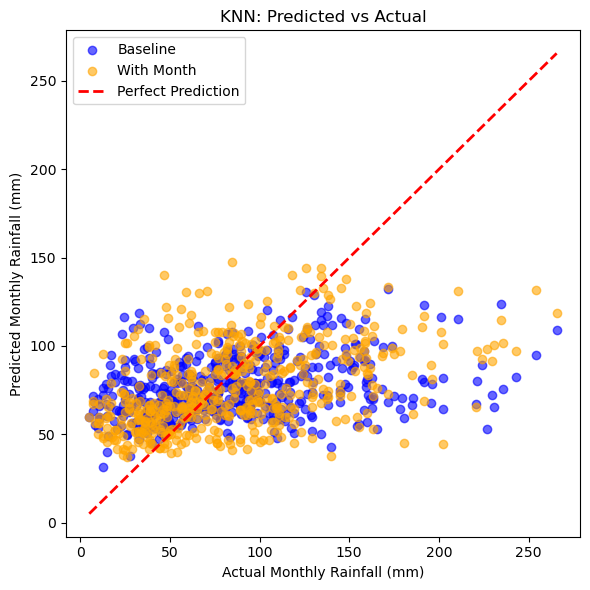

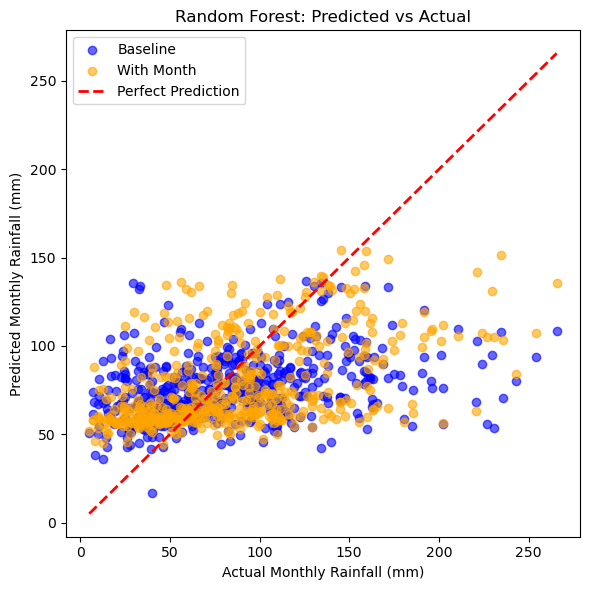

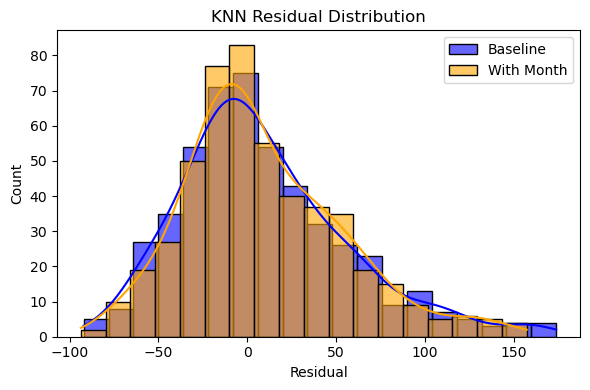

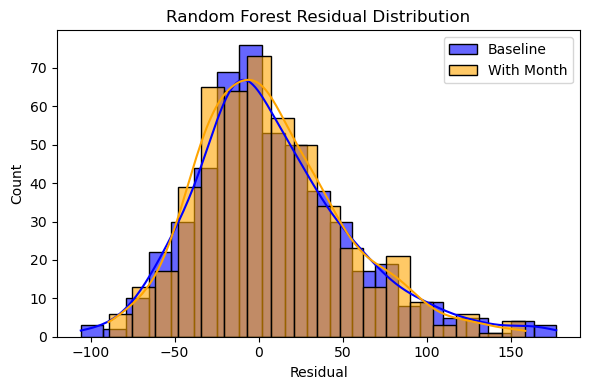

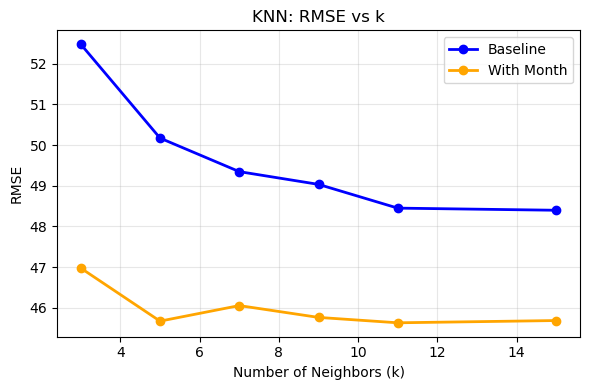

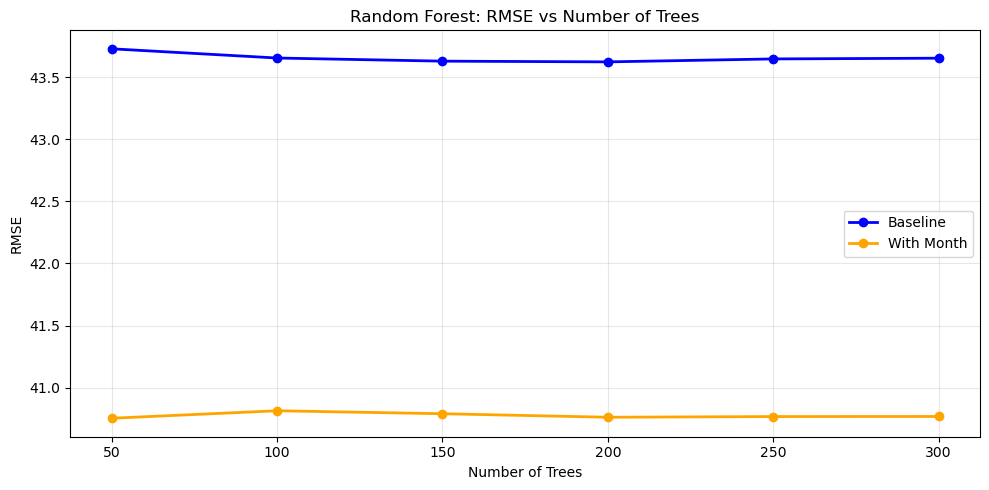

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Predicted vs Actual Plots
# KNN
plt.figure(figsize=(6, 6))
plt.scatter(test_actual_baseline, knn_baseline_preds, alpha=0.6, label='Baseline', color='blue')
plt.scatter(test_actual, knn_with_month_preds, alpha=0.6, label='With Month', color='orange')
all_actual = pd.concat([test_actual_baseline, test_actual])
all_min, all_max = all_actual.min(), all_actual.max()
plt.plot([all_min, all_max], [all_min, all_max], 'r--', label='Perfect Prediction', linewidth=2)
plt.xlabel("Actual Monthly Rainfall (mm)")
plt.ylabel("Predicted Monthly Rainfall (mm)")
plt.title("KNN: Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# Random Forest
plt.figure(figsize=(6, 6))
plt.scatter(test_actual_baseline, rf_baseline_preds, alpha=0.6, label='Baseline', color='blue')
plt.scatter(test_actual, rf_with_month_preds, alpha=0.6, label='With Month', color='orange')
all_actual_rf = pd.concat([test_actual_baseline, test_actual])
all_min_rf, all_max_rf = all_actual_rf.min(), all_actual_rf.max()
plt.plot([all_min_rf, all_max_rf], [all_min_rf, all_max_rf], 'r--', label='Perfect Prediction', linewidth=2)
plt.xlabel("Actual Monthly Rainfall (mm)")
plt.ylabel("Predicted Monthly Rainfall (mm)")
plt.title("Random Forest: Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# Residual Distribution Plots

# Residual Calcs
residuals_knn_baseline      = test_actual_baseline - knn_baseline_preds
residuals_knn_with_month    = test_actual - knn_with_month_preds
residuals_rf_baseline       = test_actual_baseline - rf_baseline_preds
residuals_rf_with_month     = test_actual - rf_with_month_preds

# KNN
plt.figure(figsize=(6, 4))
sns.histplot(residuals_knn_baseline, kde=True, label='Baseline', color='blue', alpha=0.6)
sns.histplot(residuals_knn_with_month, kde=True, label='With Month', color='orange', alpha=0.6)
plt.title("KNN Residual Distribution")
plt.xlabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()

# Random Forest
plt.figure(figsize=(6, 4))
sns.histplot(residuals_rf_baseline, kde=True, label='Baseline', color='blue', alpha=0.6)
sns.histplot(residuals_rf_with_month, kde=True, label='With Month', color='orange', alpha=0.6)
plt.title("Random Forest Residual Distribution")
plt.xlabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()


# Hyperparameter Tuning Visualisation

# KNN: RMSE vs k
k_values = [3, 5, 7, 9, 11, 15]

rmse_scores_knn_baseline = []
for k in k_values:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=k))
    ])
    model.fit(train_features_baseline, train_actual_baseline)
    y_pred_k = model.predict(test_features_baseline)
    rmse_k = math.sqrt(mean_squared_error(test_actual_baseline, y_pred_k))
    rmse_scores_knn_baseline.append(rmse_k)

rmse_scores_knn_with_month = []
for k in k_values:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=k))
    ])
    model.fit(train_features_knn_with_month, train_actual)
    y_pred_k = model.predict(test_features_knn_with_month)
    rmse_k = math.sqrt(mean_squared_error(test_actual, y_pred_k))
    rmse_scores_knn_with_month.append(rmse_k)


plt.figure(figsize=(6, 4))
plt.plot(k_values, rmse_scores_knn_baseline, marker='o', label='Baseline', color='blue', linewidth=2)
plt.plot(k_values, rmse_scores_knn_with_month, marker='o', label='With Month', color='orange', linewidth=2)
plt.title("KNN: RMSE vs k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Random Forest
rf_baseline_results_df  = pd.DataFrame(rf_grid_baseline.cv_results_)
rf_baseline_n_est       = rf_baseline_results_df['param_n_estimators'].unique()
rf_baseline_n_est       = sorted([x for x in rf_baseline_n_est if x is not None])

rf_baseline_mse_by_n_est = []
for n_est in rf_baseline_n_est:
    mask = rf_baseline_results_df['param_n_estimators'] == n_est
    best_rmse = -rf_baseline_results_df[mask]['mean_test_score'].max()
    rf_baseline_mse_by_n_est.append(best_rmse)

rf_with_month_results_df    = pd.DataFrame(rf_grid_with_month.cv_results_)
rf_with_month_n_est         = rf_with_month_results_df['param_n_estimators'].unique()
rf_with_month_n_est         = sorted([x for x in rf_with_month_n_est if x is not None])

rf_with_month_mse_by_n_est = []
for n_est in rf_with_month_n_est:
    mask = rf_with_month_results_df['param_n_estimators'] == n_est
    best_rmse = -rf_with_month_results_df[mask]['mean_test_score'].max()
    rf_with_month_mse_by_n_est.append(best_rmse)


plt.figure(figsize=(10, 5))
plt.plot(rf_baseline_n_est, rf_baseline_mse_by_n_est, label='Baseline', marker='o', color='blue', linewidth=2)
plt.plot(rf_with_month_n_est, rf_with_month_mse_by_n_est, label='With Month', marker='o', color='orange', linewidth=2)
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Random Forest: RMSE vs Number of Trees")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
